In [13]:
# Libraries

import geemap, ee # Import geemap and earth engine together

print("Libraries imported")

# Authenticate Google Earth Engine and initialize project

ee.Authenticate() # Authenticate Google Earth Engine account
ee.Initialize(project="geog-581-483717") # Initialize GEOG 581 project

print("Authenticated and initialized")

Libraries imported
Authenticated and initialized


In [14]:
# Load Landsat 5 image collection and filter for ROI, range of dates, and select the image with lowest cloud coverage

landsat5 = ee.ImageCollection("LANDSAT/LT05/C02/T1_TOA")

# Forested, mountainous landscape of northern Nepal, centered at 85.61° E, 28.17° N
langtang = ee.Geometry.Point([85.61, 28.17])

langtang_landsat = landsat5.filterBounds(langtang).filterDate('2006-07-01', '2006-09-30').sort('CLOUD_COVER').first()

langtang_landsat_info = langtang_landsat.getInfo()
print(langtang_landsat_info)
cloud_cover_info = langtang_landsat_info["properties"]["CLOUD_COVER"]
print("Cloud coverage value for langtang-landsat:", cloud_cover_info)

{'type': 'Image', 'bands': [{'id': 'B1', 'data_type': {'type': 'PixelType', 'precision': 'float'}, 'dimensions': [8001, 7121], 'crs': 'EPSG:32645', 'crs_transform': [30, 0, 245385, 0, -30, 3300315]}, {'id': 'B2', 'data_type': {'type': 'PixelType', 'precision': 'float'}, 'dimensions': [8001, 7121], 'crs': 'EPSG:32645', 'crs_transform': [30, 0, 245385, 0, -30, 3300315]}, {'id': 'B3', 'data_type': {'type': 'PixelType', 'precision': 'float'}, 'dimensions': [8001, 7121], 'crs': 'EPSG:32645', 'crs_transform': [30, 0, 245385, 0, -30, 3300315]}, {'id': 'B4', 'data_type': {'type': 'PixelType', 'precision': 'float'}, 'dimensions': [8001, 7121], 'crs': 'EPSG:32645', 'crs_transform': [30, 0, 245385, 0, -30, 3300315]}, {'id': 'B5', 'data_type': {'type': 'PixelType', 'precision': 'float'}, 'dimensions': [8001, 7121], 'crs': 'EPSG:32645', 'crs_transform': [30, 0, 245385, 0, -30, 3300315]}, {'id': 'B6', 'data_type': {'type': 'PixelType', 'precision': 'float'}, 'dimensions': [8001, 7121], 'crs': 'EPSG:

In [15]:
# Visualize a true color version of the image

langtang_rgb = langtang_landsat.select(['B3', 'B2', 'B1'])

rgb_vis = {
    "min": 0.0,
    "max": 0.4,
}

Map = geemap.Map(ee_initialize=False)
Map.centerObject(langtang, 10)
Map.addLayer(langtang_rgb, rgb_vis, 'Landsat 8 RGB')
Map

Map(center=[28.17, 85.61], controls=(WidgetControl(options=['position', 'transparent_bg'], widget=HBox(childre…

In [16]:
# Analyze the Tasseled Cap Coefficients

tc_coefficients = ee.Array([
  [0.3037, 0.2793, 0.4743, 0.5585, 0.5082, 0.1863],
  [-0.2848, -0.2435, -0.5436, 0.7243, 0.0840, -0.1800],
  [0.1509, 0.1973, 0.3279, 0.3406, -0.7112, -0.4572],
  [-0.8242, 0.0849, 0.4392, -0.0580, 0.2012, -0.2768],
  [-0.3280, 0.0549, 0.1075, 0.1855, -0.4357, 0.8085],
  [0.1084, -0.9022, 0.4120, 0.0573, -0.0251, 0.0238]
])

bands = ['B1', 'B2', 'B3', 'B4', 'B5', 'B7'] 

wet_point = ee.Geometry.Point([85.3511, 28.1976])
wet_vals = langtang_landsat.select(bands).reduceRegion(
    reducer=ee.Reducer.first(),
    geometry=wet_point,
    scale=30,
    bestEffort=True,
    maxPixels=1e9
)

dry_point = ee.Geometry.Point([85.6588, 28.7298])
dry_vals = langtang_landsat.select(bands).reduceRegion(
    reducer=ee.Reducer.first(),
    geometry=dry_point,
    scale=30,
    bestEffort=True,
    maxPixels=1e9
)

print("WET VEG:", wet_vals.getInfo())
print("DRY VEG:", dry_vals.getInfo())



WET VEG: {'B1': 0.08888793736696243, 'B2': 0.08158010989427567, 'B3': 0.06066643446683884, 'B4': 0.3331824243068695, 'B5': 0.1884404420852661, 'B7': 0.07795027643442154}
DRY VEG: {'B1': 0.17151549458503723, 'B2': 0.22493833303451538, 'B3': 0.26862651109695435, 'B4': 0.3331824243068695, 'B5': 0.4338604211807251, 'B7': 0.4091622531414032}


In [17]:
# Convert langtang to an image where each pixel stores a one dimensional array of band values, observe differences in how one pixel stores data

langtang_ir = langtang_landsat.select(['B4', 'B5', 'B7'])

langtang_array1D = langtang_landsat.select(bands).toArray()

array_flattened = langtang_array1D.arrayFlatten([bands])

gray_vis = {
    "min": 0.0,
    "max": 0.4,
}

regular_vals = langtang_landsat.reduceRegion(
    reducer=ee.Reducer.first(),
    geometry=dry_point,
    scale=30,
    bestEffort=True,
    maxPixels=1e9
)

array1D_vals = langtang_array1D.reduceRegion(
    reducer=ee.Reducer.first(),
    geometry=dry_point,
    scale=30,
    bestEffort=True,
    maxPixels=1e9
)

print(regular_vals.getInfo())
print(array1D_vals.getInfo())

Map2 = geemap.Map(ee_initialize=False)
Map2.centerObject(langtang, 10)
Map2.addLayer(langtang_rgb, rgb_vis, 'Landsat 5 True Color RGB')
Map2.addLayer(langtang_ir, rgb_vis, 'Landsat 5 False Color IR')
Map2.addLayer(array_flattened, rgb_vis, 'Array 1D')
Map2

{'B1': 0.17151549458503723, 'B2': 0.22493833303451538, 'B3': 0.26862651109695435, 'B4': 0.3331824243068695, 'B5': 0.4338604211807251, 'B6': 301.9180603027344, 'B7': 0.4091622531414032, 'QA_PIXEL': 5440, 'QA_RADSAT': 0, 'SAA': 14240, 'SZA': 3700, 'VAA': -9165, 'VZA': 60}
{'array': [0.17151549458503723, 0.22493833303451538, 0.26862651109695435, 0.3331824243068695, 0.4338604211807251, 0.4091622531414032]}


Map(center=[28.17, 85.61], controls=(WidgetControl(options=['position', 'transparent_bg'], widget=HBox(childre…

In [18]:
# Convert to a 2D array

langtang_array2D = langtang_array1D.toArray(1)

array2D_vals = langtang_array2D.reduceRegion(
    reducer=ee.Reducer.first(),
    geometry=dry_point,
    scale=30,
    bestEffort=True,
    maxPixels=1e9
)

print(array2D_vals.getInfo())

array2d_flattened = langtang_array1D.arrayFlatten([bands])

Map3 = geemap.Map(ee_initialize=False)
Map3.centerObject(langtang, 10)
Map3.addLayer(langtang_rgb, rgb_vis, 'Landsat 5 True Color RGB')
Map3.addLayer(langtang_ir, rgb_vis, 'Landsat 5 False Color IR')
Map3.addLayer(array2d_flattened, rgb_vis, 'Array 1D')
Map3.addLayer(langtang_array2D, rgb_vis, 'Array 2D')
Map3

{'array': [[0.17151549458503723], [0.22493833303451538], [0.26862651109695435], [0.3331824243068695], [0.4338604211807251], [0.4091622531414032]]}


Map(center=[28.17, 85.61], controls=(WidgetControl(options=['position', 'transparent_bg'], widget=HBox(childre…

In [19]:
# Apply the matrix multiplication

tc_image = ee.Image(tc_coefficients).matrixMultiply(langtang_array2D).arrayProject([0])
tc_image_no_array = ee.Image(tc_coefficients).matrixMultiply(langtang_array2D)

Map4 = geemap.Map(ee_initialize=False)
Map4.centerObject(langtang, 10)
Map4.addLayer(tc_image, gray_vis, 'Array')
Map4.addLayer(tc_image_no_array, gray_vis, 'No Array')
Map4

Map(center=[28.17, 85.61], controls=(WidgetControl(options=['position', 'transparent_bg'], widget=HBox(childre…

In [20]:
# Flatten and visualize the image with the TC transform applied

tc_flattened = tc_image.arrayFlatten(
[['Brightness', 'Greenness', 'Wetness', 'fourth', 'fifth', 'sixth']])

tc_vizParams = {
  'bands': ['Brightness', 'Greenness', 'Wetness'],
  'min': -0.1, 'max': [0.5, 0.3, 0.7]
}

tc_vals = tc_flattened.reduceRegion(
    reducer=ee.Reducer.first(),
    geometry=dry_point,
    scale=30,
    bestEffort=True,
    maxPixels=1e9
)

print(tc_vals.getInfo())

Map5 = geemap.Map(ee_initialize=False)
Map5.centerObject(langtang, 10)
Map5.addLayer(tc_flattened, tc_vizParams, 'TC components')
Map5



{'Brightness': 0.7251212641149759, 'Greenness': -0.04552636864483353, 'Wetness': -0.22380392573177812, 'fifth': 0.18854941806793213, 'fourth': -0.049573018026351945, 'sixth': -0.05573344391286372}


Map(center=[28.17, 85.61], controls=(WidgetControl(options=['position', 'transparent_bg'], widget=HBox(childre…

In [21]:
false_color = ['B4', 'B3', 'B2']

fc_vis = {'bands': false_color,
          'min': 0,
          'max': 1,
}

langtang_fc = langtang_landsat.select(false_color)

Map6 = geemap.Map(ee_initialize=False)
Map6.centerObject(langtang, 10)
Map6.addLayer(tc_flattened, tc_vizParams, 'TC components')
Map6.addLayer(langtang_fc, fc_vis, 'False Color')
Map6

Map(center=[28.17, 85.61], controls=(WidgetControl(options=['position', 'transparent_bg'], widget=HBox(childre…

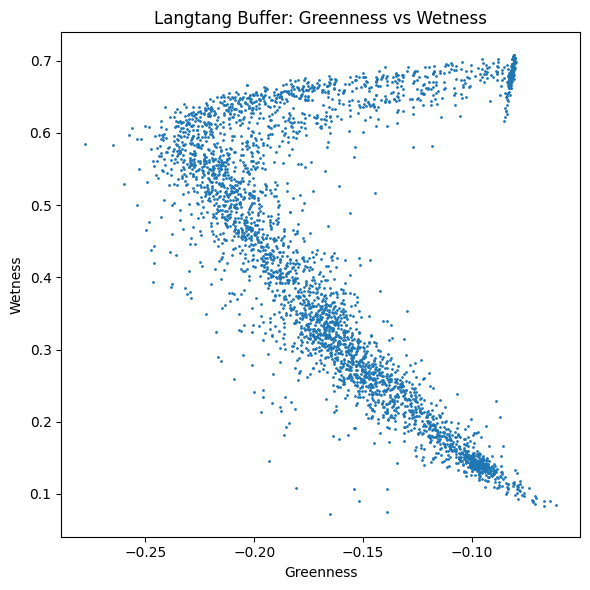

In [22]:
# Generate a scatterplot of greenness vs wetness

import matplotlib.pyplot as plt

langtang_buffer = langtang.buffer(1000)

# Set-up reducer
scale = 30
values = tc_flattened.reduceRegion(ee.Reducer.toList(), langtang_buffer, scale)


# Set-up scatter plot
x = values.get("Greenness").getInfo()
y = values.get("Wetness").getInfo()

# Generate scatter plot
plt.figure(figsize=(6, 6))
plt.scatter(x, y, s=1)
plt.xlabel("Greenness")
plt.ylabel("Wetness")
plt.title("Langtang Buffer: Greenness vs Wetness")
plt.tight_layout()
plt.show()

In [23]:
# Visualize the buffered region

Map7 = geemap.Map(ee_initialize=False)
Map7.centerObject(langtang, 15)
Map7.addLayer(tc_flattened, tc_vizParams, 'TC components')
Map7.addLayer(ee.FeatureCollection([ee.Feature(langtang_buffer)]).style(**{"color": "yellow", "fillColor": "00000000", "width": 3,}),{}, "Langtang buffer")
Map7

Map(center=[28.17, 85.61], controls=(WidgetControl(options=['position', 'transparent_bg'], widget=HBox(childre…

In [24]:
# Terrain correction

import math

def toRadians(img):
    return img.toFloat().multiply(math.pi).divide(180)

DEM = ee.Image("USGS/SRTMGL1_003")
shade = ee.Terrain.hillshade(DEM)
SLP = toRadians(ee.Terrain.slope(DEM))
ASP = toRadians(ee.Terrain.aspect(DEM))

AZ = ee.Number(langtang_landsat.get("SUN_AZIMUTH"))
print(AZ.getInfo())
ZE = ee.Number(langtang_landsat.get("SUN_ELEVATION"))
zenith_actual = ee.Number(90).subtract(ZE)

AZ_R = toRadians(ee.Image.constant(AZ))
ZE_R = toRadians(ee.Image.constant(zenith_actual))

IC = (
    AZ_R.subtract(ASP).cos()
    .multiply(SLP.sin())
    .multiply(ZE_R.sin())
    .add(ZE_R.cos().multiply(SLP.cos()))
)

ic_min = 0.1
ic_max = 1.0
IC_clamped = IC.clamp(ic_min, ic_max)

cos_ZE = ZE_R.cos()
langtang_corrected = langtang_landsat.multiply(cos_ZE).divide(IC_clamped)

imageVisParam = {"bands": ["B4", "B3", "B2"], "min": 0.0, "max": 0.4}

Map8 = geemap.Map(ee_initialize=False)
Map8.centerObject(langtang, 10)
Map8.addLayer(shade, {}, "shade")
Map8.addLayer(IC, {}, "illumination conditions")
Map8.addLayer(langtang_fc, fc_vis, "original true color")
Map8.addLayer(langtang_corrected, imageVisParam, "corrected")
Map8

142.43251582


Map(center=[28.17, 85.61], controls=(WidgetControl(options=['position', 'transparent_bg'], widget=HBox(childre…

In [ ]:
# Export to Google Drive
region = langtang.buffer(10000).bounds()

task_drive = ee.batch.Export.image.toDrive(
    image=langtang_corrected.select(["B3", "B2", "B1"]),
    description="langtang_corrected",
    folder="gee_exports",
    fileNamePrefix="langtang_corrected",
    region=region,
    scale=30,
    maxPixels=1e13
)
task_drive.start()

task_drive = ee.batch.Export.image.toDrive(
    image=langtang_corrected.select(["B4", "B3", "B2"]),
    description="langtang_fc",
    folder="gee_exports",         
    fileNamePrefix="langtang_uncorrected",
    region=region,
    scale=30,
    maxPixels=1e13
)
task_drive.start()

print("Drive task started:", task_drive.id)

Drive task started: 5ZL2P6O4LPZJA22XQAWQBPMZ


In [ ]:
# Export to an Earth Engine Asset
region = langtang.buffer(10000).bounds()

task_asset = ee.batch.Export.image.toAsset(
    image=langtang_rgb,
    description="langtang_fc",
    assetId="users/riccellm/langtang_uncorrected", 
    region=region,
    scale=30,
    maxPixels=1e13
)
task_asset.start()

task_asset = ee.batch.Export.image.toAsset(
    image=langtang_corrected,
    description="langtang_corrected",
    assetId="users/riccellm/langtang_corrected", 
    region=region,
    scale=30,
    maxPixels=1e13
)
task_asset.start()

print("Asset task started:", task_asset.id)

Asset task started: DOVQM5QVCWFKCOQTF2IJSYLV
